# Lattice filter library utilities

## Introduction

In most of the applications, we have an fir or iir filter designed in terms of poles or transfer function and what we want is the equivalence lattice filter. The "filter_lattice" library is for such use. Having had a transfer function, tf, using the recursive Levinson-Durbin algorithm, it finds the equivalent lattice filter. The library is designed to find either pure fir or pure iir filters. Also all the designed filters are symmetric-reflection coefficient implementations. Non-symmetric ones may or may not be under development.

This notebook follows the theory and algorithms described in [2]. Specifically, all the FIR filters are applied as the following picture:

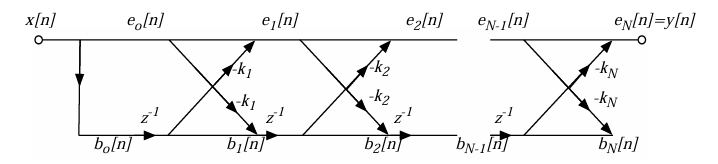

In [1]:
from IPython.display import Image, display
display(Image(filename='firLattice.PNG'))

The IIR filters also:

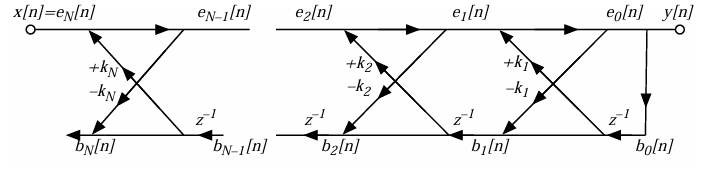

In [2]:
from IPython.display import Image, display
display(Image(filename='iirLattice.PNG'))

Any set of given coefficients given to this library turns given coefficients $\{ a_0,a_1,a_2,..., a_N\}$ into the following form:
$$
\{1,-\frac{a_1}{a_0}, ..., -\frac{a_i}{a_0}, ..., -\frac{a_N}{a_0} \}
$$
Therefore the best practice is to not give the first coefficient as $0$ and moreover if it is not 1, one can always put a pure gain in the line of design filters. Overall the proper input is assumed to be:
$$
A(z) = 1-\sum_{n=1}^N a_nz^{-n}
$$
Even if the $a_0$ is not 0 in the input the library will turn normalize by the 0th coefficient given that it is no division by 0. 

## Imports

In [3]:
%reload_ext autoreload
%autoreload 2

import sys
import os

# Add the parent directory to Python path to import the library
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from filter_lattice import (
    FIRFilter, IIRFilter, LatticeFilter,
    FIRLatticeFilter, IIRLatticeFilter,
    tf2lattice
)

## API use cases

### Non-Symmetric FIR filter example design

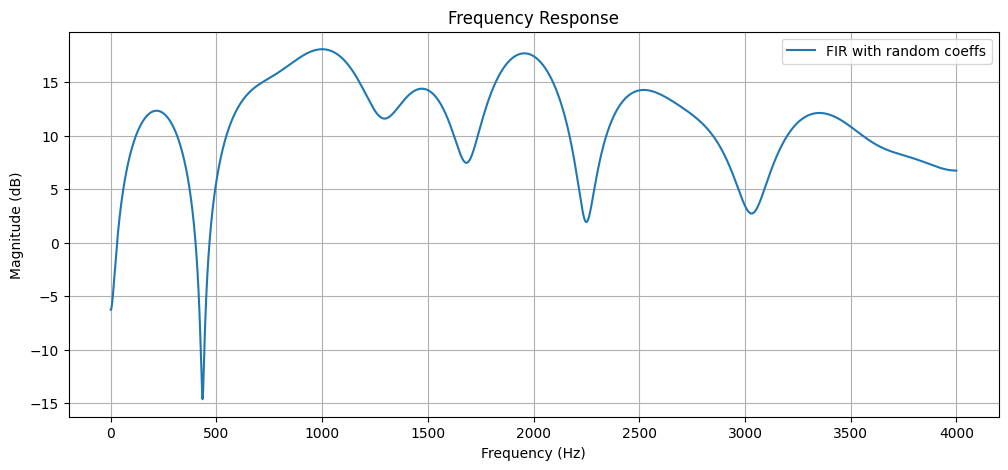

Impulse response: [ 1.          1.46237065 -1.49086121 -0.81176403  1.25136572  1.26721001
  0.64691054 -0.01114177  0.1121621  -1.4819843   0.08147676 -1.33064202
  0.43851766  1.49323461  0.25995569  0.14547583  0.32706557 -0.12482272
 -0.97499889 -1.45017147 -0.32266565]


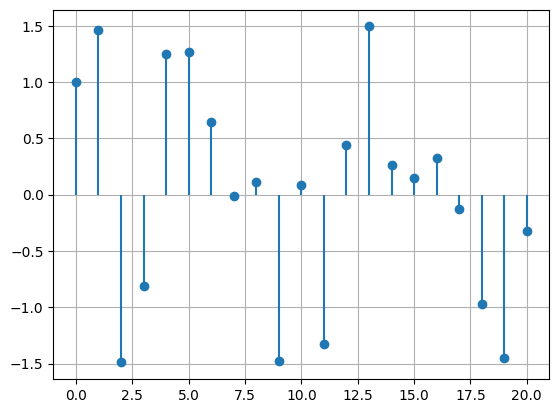

In [4]:
fs = 8000  # Sampling frequency

# FIR Lowpass Filter Design (cutoff at 3000 Hz)
numtaps = 21  # Filter order + 1 (choose as needed)
fir_coeffs = np.random.uniform(-1, 1, numtaps)
fir_coeffsU = fir_coeffs/fir_coeffs[0]
# Frequency response plots
w_fir, h_fir = signal.freqz(fir_coeffsU, worN=8000, fs=fs)

plt.figure(figsize=(12, 5))
plt.plot(w_fir, 20 * np.log10(np.abs(h_fir)), label='FIR with random coeffs')
plt.title('Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()

def plot_impulse_response(response, label, n=4):
    print(f"Impulse response: {response}")
    plt.stem(np.arange(n), response, linefmt='-', markerfmt='o', basefmt=' ', label=label)
    plt.grid(True)

# Print coefficients
plot_impulse_response(fir_coeffsU,"FIR filter", len(fir_coeffs))

### API usage

**tf2lattice** function turns transfer function into a lattice filter object. One can use **.reflection_coeffs** to get the reflections coefficcients computed.

In [5]:
fir_lattice = tf2lattice(fir_coeffs, type_of_filter="FIR")
print(f"Lattice reflection coefficients: {fir_lattice.reflection_coeffs}")

Lattice reflection coefficients: [ 0.74751235  1.08516535  3.65395749 -2.57200543 -1.41057976 -0.97691922
 -5.25365845  0.77068716 -0.30720227  0.01599888  0.61673351  0.63654758
  0.5671723   2.75568919 -1.0093242   9.83968673  1.73674427 -2.1462716
  1.09200694  0.32266565]


Then one can use **.filter** method on the returned object to apply the filter to any given input:

Impulse response: [ 1.          1.46237065 -1.49086121 -0.81176403  1.25136572  1.26721001
  0.64691054 -0.01114177  0.1121621  -1.4819843   0.08147676 -1.33064202
  0.43851766  1.49323461  0.25995569  0.14547583  0.32706557 -0.12482272
 -0.97499889 -1.45017147 -0.32266565]


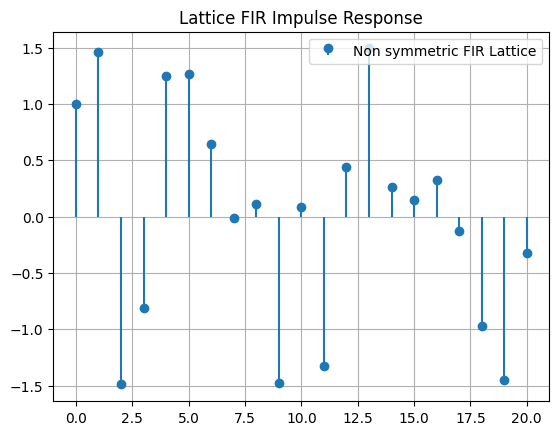

In [6]:
response_fir = fir_lattice.filter([1])
plot_impulse_response(response_fir, 'Non symmetric FIR Lattice', len(fir_coeffs))
plt.title('Lattice FIR Impulse Response')
plt.legend()
plt.grid(True)
plt.show()


Then we compare the frequency responses:

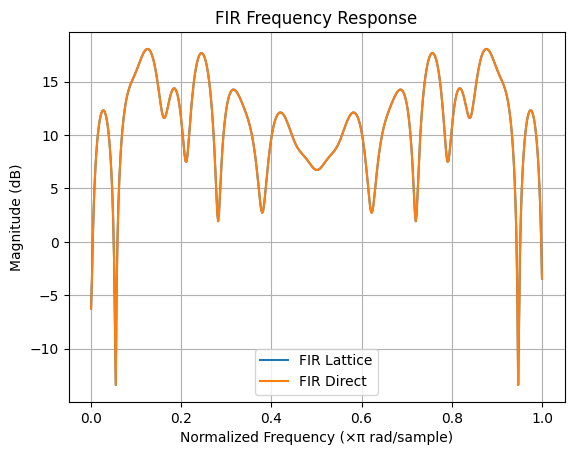

In [7]:
lattice_ir = response_fir
w = np.linspace(0, np.pi, 512)
lattice_fft = np.fft.fft(lattice_ir, 512)
fir_fft = np.fft.fft(fir_coeffsU, 512)
plt.plot(w / np.pi, 20 * np.log10(np.abs(lattice_fft) + 1e-12), label='FIR Lattice')
plt.plot(w / np.pi, 20 * np.log10(np.abs(fir_fft) + 1e-12), label='FIR Direct')
plt.title('FIR Frequency Response')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()

One can use **.tf** method on each lattice filter to confirm the transfer function of the filter:

In [8]:
# Test transfer function recovery
recovered_num, recovered_den = fir_lattice.tf()
print(f"Original coefficients: {fir_coeffsU}")
print(f"Recovered coefficients: {recovered_num}")

Original coefficients: [ 1.          1.46237065 -1.49086121 -0.81176403  1.25136572  1.26721001
  0.64691054 -0.01114177  0.1121621  -1.4819843   0.08147676 -1.33064202
  0.43851766  1.49323461  0.25995569  0.14547583  0.32706557 -0.12482272
 -0.97499889 -1.45017147 -0.32266565]
Recovered coefficients: [ 1.          1.46237065 -1.49086121 -0.81176403  1.25136572  1.26721001
  0.64691054 -0.01114177  0.1121621  -1.4819843   0.08147676 -1.33064202
  0.43851766  1.49323461  0.25995569  0.14547583  0.32706557 -0.12482272
 -0.97499889 -1.45017147 -0.32266565]


Finally **.plot** method for visualization of the object:

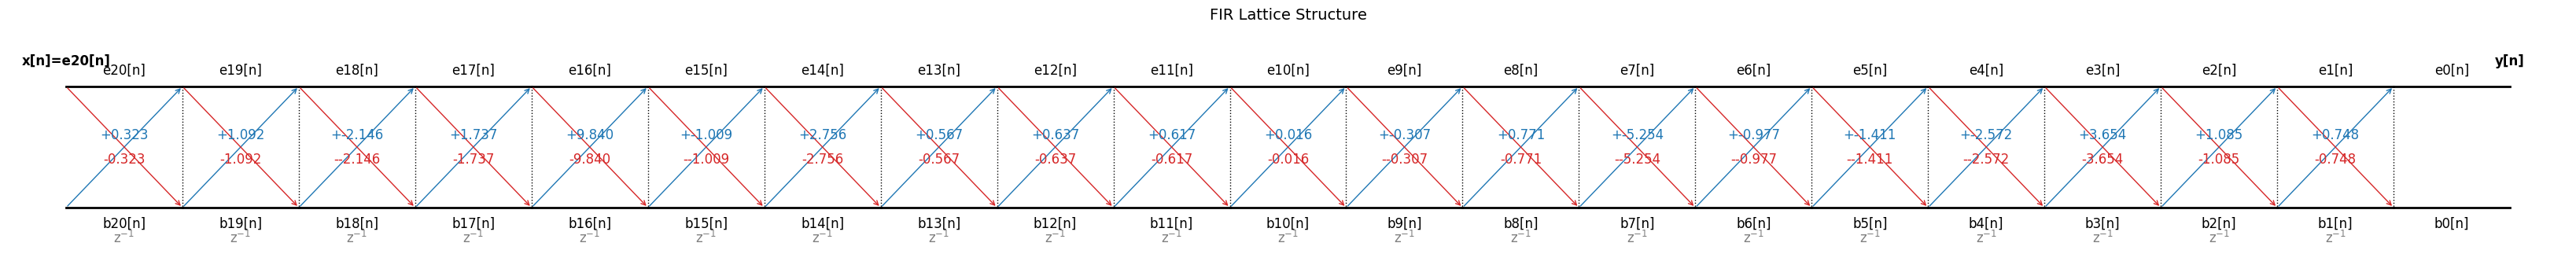

In [9]:
fir_lattice.plot()

### Symmetric linear phase FIR's

The typical Levinson-Durbin recursion or Schur recursion used to derive reflection coefficients $k_i$ from a polynomial assumes strictly positive-definite autocorrelation matrix — which fails when:
- The FIR has symmetric coefficients.
- This causes zeros exactly on the unit circle, so during recursion, a division by zero (or near-zero) occurs.

One can transform a symmetric FIR into a minimum-phase equivalent FIR with the same magnitude response using the cepstrum-based technique:

In [10]:
from scipy.signal import minimum_phase

# FIR Lowpass Filter Design (cutoff at 3000 Hz)
fir_cutoff = 3000  # Hz
numtaps = 21  # Filter order + 1 (choose as needed)
firSymmcoeffs = signal.firwin(numtaps, fir_cutoff, fs=fs, pass_zero='lowpass')
h_min_phase = minimum_phase(firSymmcoeffs, method='homomorphic')
h_min_phaseU = h_min_phase/h_min_phase[0]

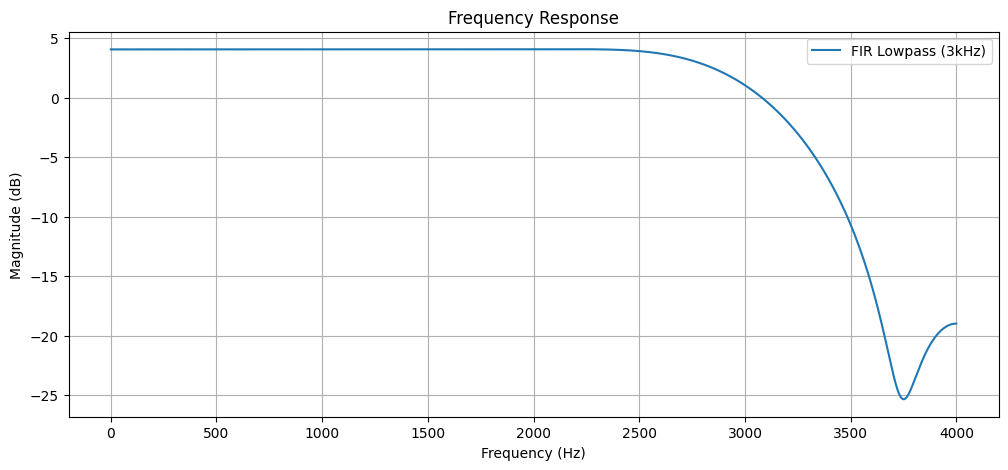

Impulse response: [ 1.          0.87524963 -0.33190541 -0.00350345  0.13331365 -0.12453302
  0.06385081 -0.01320504 -0.00752079  0.00793457 -0.00322674]


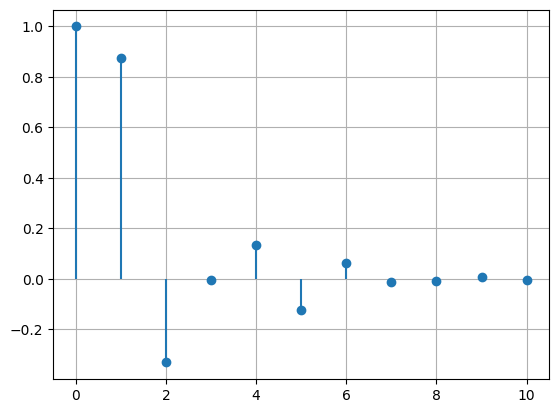

In [11]:

# Frequency response plots
w_fir, h_fir = signal.freqz(h_min_phaseU, worN=8000, fs=fs)

plt.figure(figsize=(12, 5))
plt.plot(w_fir, 20 * np.log10(np.abs(h_fir)), label='FIR Lowpass (3kHz)')
plt.title('Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()

def plot_impulse_response(response, label, n=4):
    print(f"Impulse response: {response}")
    plt.stem(np.arange(n), response, linefmt='-', markerfmt='o', basefmt=' ', label=label)
    plt.grid(True)

# Print coefficients (optional)
plot_impulse_response(h_min_phaseU,"FIR filter", len(h_min_phaseU))

### Equivalent Lattice design

Like the previous example **tf2lattice** function and **.filter** method turn a transfer function into a lattice filter and filter a given input accordingly. If we hadn't done the non-symmetrization part, the algorithm would return a division by 0.

Lattice reflection coefficients: [-0.95713768 -0.19728868  0.40402345 -0.31615849  0.17136264 -0.0530096
 -0.00612387  0.01801101 -0.01075888  0.00322674]
Impulse response: [ 1.          0.87524963 -0.33190541 -0.00350345  0.13331365 -0.12453302
  0.06385081 -0.01320504 -0.00752079  0.00793457 -0.00322674]


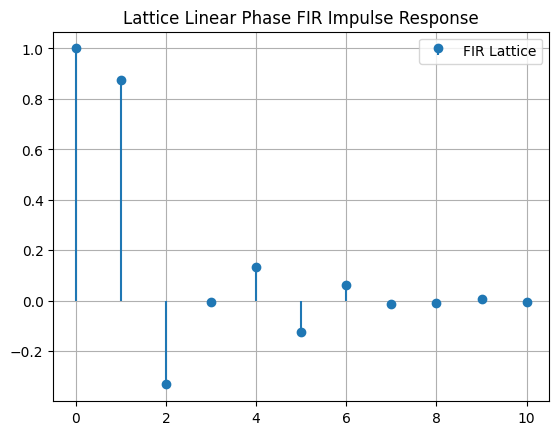

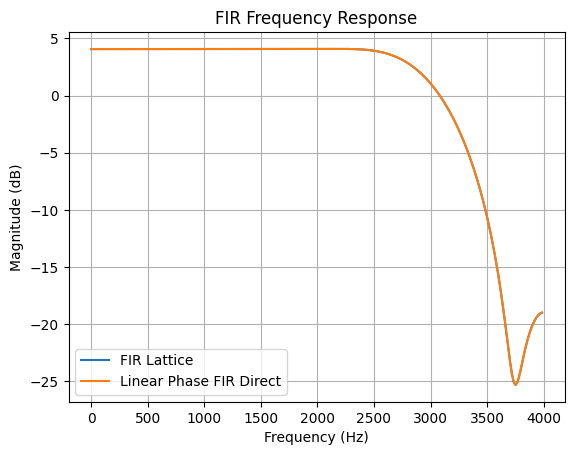

In [12]:
fir_lattice = tf2lattice(h_min_phaseU, type_of_filter="FIR")
print(f"Lattice reflection coefficients: {fir_lattice.reflection_coeffs}")
plot_impulse_response(fir_lattice.filter([1]), 'FIR Lattice', len(h_min_phaseU))
plt.title('Lattice Linear Phase FIR Impulse Response')
plt.legend()
plt.grid(True)
plt.show()

lattice_ir = fir_lattice.filter([1])
N = 512
fs = 8000

# FFT and shift
lattice_fft = np.fft.fftshift(np.fft.fft(lattice_ir, N))
fir_fft = np.fft.fftshift(np.fft.fft(h_min_phaseU, N))
freqs = np.fft.fftshift(np.fft.fftfreq(N, d=1/fs))

# Only plot 0 to 4000 Hz
mask = (freqs >= 0) & (freqs <= fs/2)

plt.plot(freqs[mask], 20 * np.log10(np.abs(lattice_fft[mask]) + 1e-12), label='FIR Lattice')
plt.plot(freqs[mask], 20 * np.log10(np.abs(fir_fft[mask]) + 1e-12), label='Linear Phase FIR Direct')
plt.title('FIR Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()

Original coefficients: [ 1.          0.87524963 -0.33190541 -0.00350345  0.13331365 -0.12453302
  0.06385081 -0.01320504 -0.00752079  0.00793457 -0.00322674]
Recovered coefficients: [ 1.          0.87524963 -0.33190541 -0.00350345  0.13331365 -0.12453302
  0.06385081 -0.01320504 -0.00752079  0.00793457 -0.00322674]


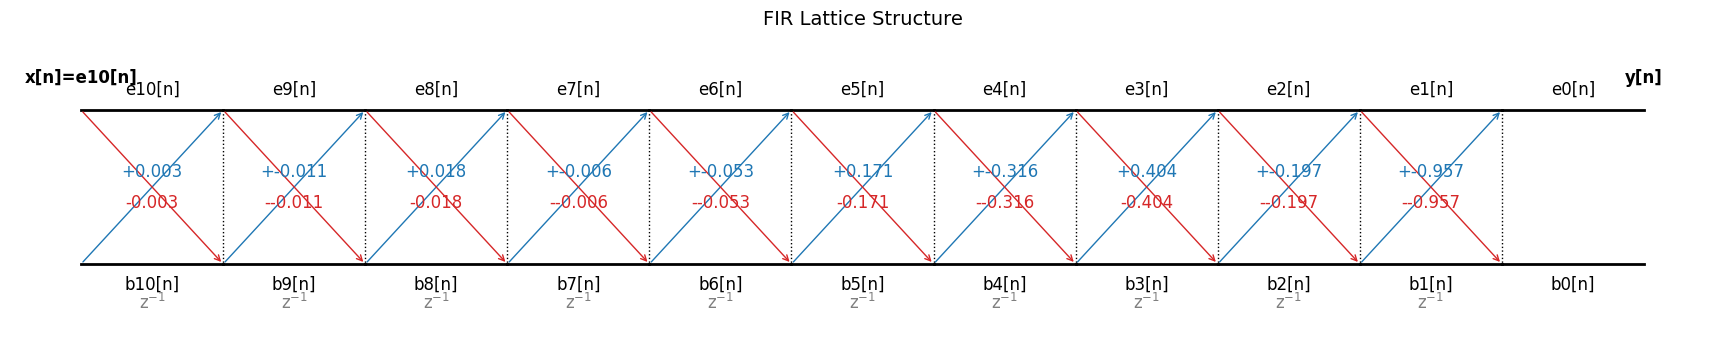

In [13]:
# Test transfer function recovery
recovered_num, recovered_den = fir_lattice.tf()
print(f"Original coefficients: {h_min_phaseU}")
print(f"Recovered coefficients: {recovered_num}")
fir_lattice.plot()

### IIR example design. Poles at 400Hz and 3000Hz.

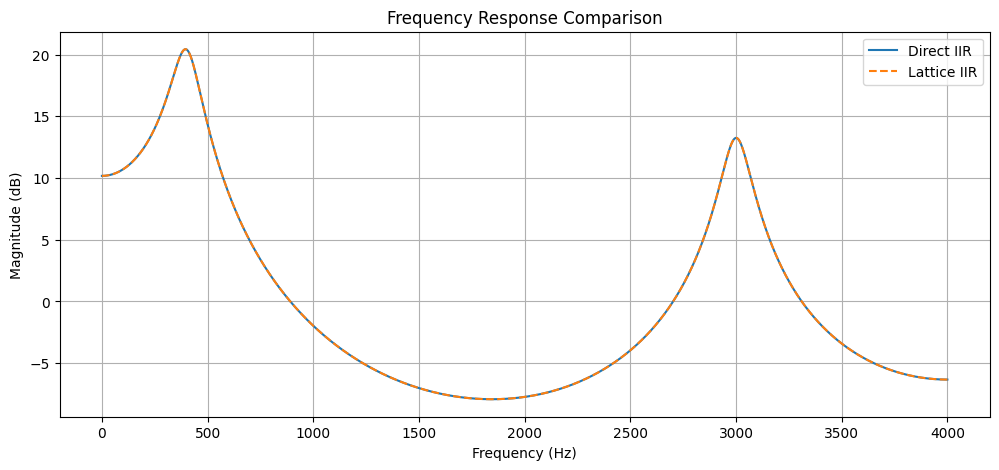

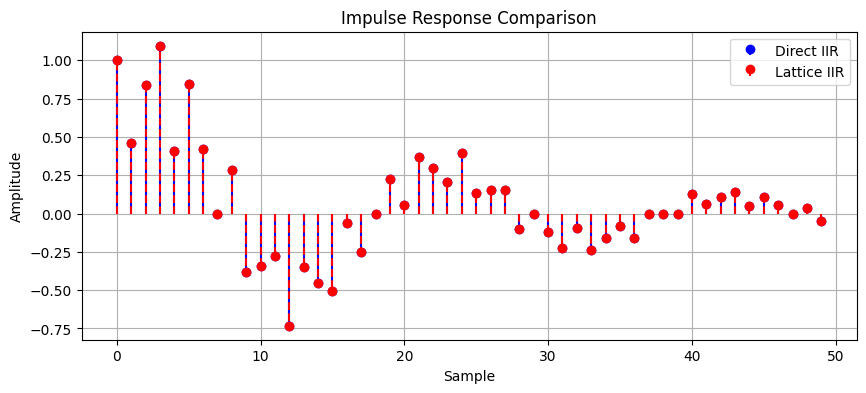

In [14]:

# --- 1. Design IIR filter with specified poles ---
fs = 8000  # Sampling frequency

# Define pole frequencies and radii
f1 = 400    # Hz
f2 = 3000   # Hz
r1 = 0.95   # Radius for pole 1
r2 = 0.95   # Radius for pole 2

# Calculate pole locations in the z-plane
theta1 = 2 * np.pi * f1 / fs
theta2 = 2 * np.pi * f2 / fs
p1 = r1 * np.exp(1j * theta1)
p2 = r2 * np.exp(1j * theta2)

# For a real filter, include complex conjugates
poles = [p1, np.conj(p1), p2, np.conj(p2)]

# Get denominator coefficients A(z)
A = np.poly(poles)  # Returns coefficients for A(z) = 1 - a1 z^-1 - a2 z^-2 - ...

# --- 2. Create lattice filter from A(z) ---
from filter_lattice.lattice import tf2lattice

lattice_iir = tf2lattice(A, type_of_filter="IIR")

# --- 3. Frequency response comparison ---
w, h_direct = signal.freqz([1.0], A, worN=8000, fs=fs)
_, h_lattice = signal.freqz([1.0], lattice_iir.tf()[1], worN=8000, fs=fs)

plt.figure(figsize=(12, 5))
plt.plot(w, 20 * np.log10(np.abs(h_direct) + 1e-20), label='Direct IIR')
plt.plot(w, 20 * np.log10(np.abs(h_lattice) + 1e-20), '--', label='Lattice IIR')
plt.title('Frequency Response Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()

# --- 4. Impulse response comparison ---
impulse = np.zeros(50)
impulse[0] = 1.0
imp_response_direct = signal.lfilter([1.0], A, impulse)
imp_response_lattice = lattice_iir.filter(impulse)

plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(imp_response_direct)), imp_response_direct, linefmt='b-', markerfmt='bo', basefmt=' ', label='Direct IIR')
plt.stem(np.arange(len(imp_response_lattice)), imp_response_lattice, linefmt='r--', markerfmt='ro', basefmt=' ', label='Lattice IIR')
plt.title('Impulse Response Comparison')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Original coefficients: [ 1.         -0.4635045  -0.62271963 -0.41831281  0.81450625]
Recovered coefficients: [ 1.         -0.4635045  -0.62271963 -0.41831281  0.81450625]


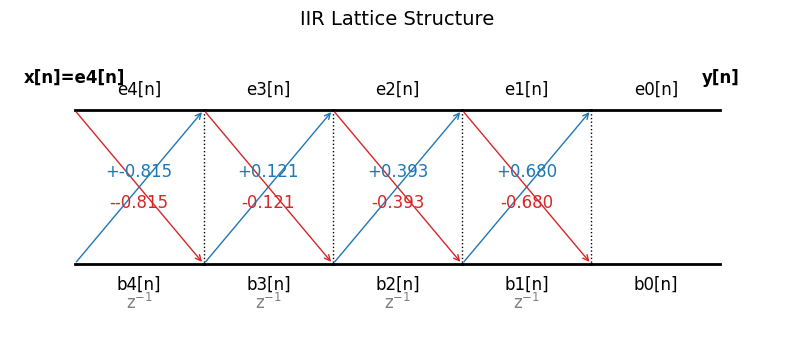

In [15]:
# Test transfer function recovery
recovered_num, recovered_den = lattice_iir.tf()
print(f"Original coefficients: {A}")
print(f"Recovered coefficients: {recovered_den}")
lattice_iir.plot()

### Stability of IIR filters
According to [1] and [2], an IIR lattice filter is stable iff all its reflection coefficients are strictly in $(-1,1)$. This utility is considered via calling on **.is_stable** method on the IIR lattice onjects:

In [16]:
if lattice_iir.is_stable():
    print("The lattice iir filter seems to be stable.")
else:
    print("Your lattice filter is not stable!")

The lattice iir filter seems to be stable.


# References

[1]: Proakis, J. G., & Manolakis, D. G. (2007). Digital Signal Processing (4th ed.). Pearson Prentice Hall.

[2]: Carnegie Mellon University, Department of Electrical & Computer Engineering.  
    **DSP-I: Digital Signal Processing I (18-791), Fall Semester, 2005.**  
    Notes on Linear Prediction and Lattice Filters.


